# Pendulum motion in python
This notebook is based on [lukepolson's work](https://github.com/lukepolson/youtube_channel/blob/main/Python%20Metaphysics%20Series/vid4.ipynb)

In [2]:
import numpy as np
import sympy as smp
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib.animation

## Background

Position confined to some 1D path: $x=x(\theta)$ and $y=y(\theta)$

A few examples:
- Parabola: $x=\theta$ and $y=\theta^2$
- Simple Pendulum: $x=cos(\theta)$ and $y=sin(\theta)$
- Tautochrome: $x=sin(2\theta)$ and $y=1-cos(2\theta)$
- and there are many more...

Kinetic Energy: $T=\frac{1}{2}m(\dot{x}^2+\dot{y}^2)$

Potential Energy: $V=mgy$

The Lagrangian: $L=T-V$

Lagranges Equation: $\frac{\partial L}{\partial \theta}-\frac{d}{dt}\frac{\partial L}{\partial \dot{\theta}}=0$

## Define variables

In [3]:
# Define time, mass, gravitational constant
t, m, g = smp.symbols('t m g')
# Define theta
the = smp.symbols(r'\theta', cls=smp.Function)
# Define that theta is a function of time
the = the(t)
# Define theta's derivative and second derivative with respect to time
the_d = smp.diff(the, t)
the_dd = smp.diff(the_d, t)

In [4]:
the_dd

Derivative(\theta(t), (t, 2))

Define $x$ and $y$ to be functions of $\theta$

In [5]:
x, y = smp.symbols('x y', cls=smp.Function)
x = x(the)
y = y(the)

Define the possible paths as an enum

In [6]:
from enum import Enum

class Path(Enum):
    PARABOLA = 'Parabola'
    TAUTOCHROME = 'Tautochrome'

Decide what path you want to solve and visualise

In [7]:
path = Path.TAUTOCHROME

In [8]:
if path == Path.PARABOLA:
    x = the
    y = the**2
    
if path == Path.TAUTOCHROME:
    x = smp.sin(2*the) + 2*the
    y = 1-smp.cos(2*the)

x_f = smp.lambdify(the, x)
y_f = smp.lambdify(the, y)

To see what the shape of the path is:

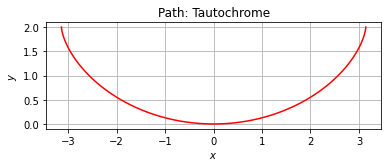

In [27]:
the_temp = np.linspace(-np.pi/2, np.pi/2, 100)
plt.plot(x_f(the_temp), y_f(the_temp), '-r')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(f'Path: {path.value}')
plt.axis('scaled')
plt.grid(True)

Define $T$, $V$, and $L$

In [10]:
T = 1/2 * m * (smp.diff(x, t)**2 + smp.diff(y, t)**2)
V = m * g * y
L = T - V

In [11]:
L

-g*m*(1 - cos(2*\theta(t))) + 0.5*m*((2*cos(2*\theta(t))*Derivative(\theta(t), t) + 2*Derivative(\theta(t), t))**2 + 4*sin(2*\theta(t))**2*Derivative(\theta(t), t)**2)

## Compute Lagrange's Equation

$\frac{\partial L}{\partial \theta}-\frac{d}{dt}\frac{\partial L}{\partial \dot{\theta}}=0$

In [12]:
LE = smp.diff(L, the) - smp.diff(smp.diff(L, the_d), t)
LE = LE.simplify()

In [13]:
LE

m*(-2.0*g*sin(2*\theta(t)) + 8.0*sin(2*\theta(t))*Derivative(\theta(t), t)**2 - 8.0*cos(2*\theta(t))*Derivative(\theta(t), (t, 2)) - 8.0*Derivative(\theta(t), (t, 2)))

## Solve for $\frac{d^2 \theta}{dt^2}$

Using an Ordinary Differential Equation (ODE) solver.

Our system of equations will then be:
$$\frac{d \theta}{dt} = \omega$$
$$\frac{d \omega}{dt} = \frac{d^2 \theta}{dt^2} = \text{whatever is returned}$$


In [14]:
deriv_1 = the_d
deriv_2 = smp.solve(LE, the_dd)[0]

In [15]:
deriv_2

0.25*(-g + 4.0*Derivative(\theta(t), t)**2)*tan(\theta(t))

## Convert it to a numpy expression

In [16]:
deriv2_f = smp.lambdify((g, the, the_d), deriv_2)
deriv1_f = smp.lambdify(the_d, deriv_1)

## Create ODE

$S=(\theta, \omega)$

In [17]:
def dSdt(S, t):
    return [
        deriv1_f(S[1]), # = omega = dtheta/dt
        deriv2_f(g, S[0], S[1]) # = domega/dt
    ]

## Solve

In [18]:
t = np.linspace(0, 20, 500)
g = 9.81
if path == Path.PARABOLA:
    y0_1 = [2, 0]
    y0_2 = [3, 0]
if path == Path.TAUTOCHROME:
    y0_1 = [np.pi/4, 0]
    y0_2 = [np.pi/5, 0]
ans1 = scipy.integrate.odeint(dSdt, y0=y0_1, t=t) # Initial conditions: theta = 2, omega = 0 (starting from rest)
ans2 = scipy.integrate.odeint(dSdt, y0=y0_2, t=t)

## Plot

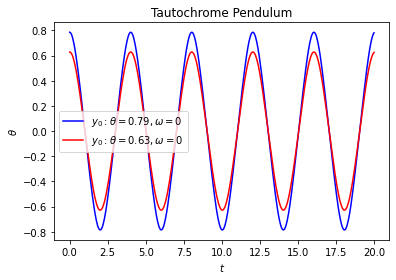

In [19]:
def get_line_label(y0) -> str:
    return rf'$y_0: \theta={round(y0[0], 2)}, \omega={round(y0[1], 2)}$'
plt.plot(t, ans1.T[0], color = 'blue', label=get_line_label(y0_1))
plt.plot(t, ans2.T[0], color = 'red', label=get_line_label(y0_2))
plt.title(f'{path.value} Pendulum')
plt.ylabel(r'$\theta$')
plt.xlabel(r'$t$')
plt.legend();

In [20]:
def get_xy(theta):
    return x_f(theta), y_f(theta)

In [21]:
x1, y1 = get_xy(ans1.T[0])
x2, y2 = get_xy(ans2.T[0])

In [31]:
%%capture
def animate(i):
    ln1.set_data([x1[i]], [y1[i]])
    ln2.set_data([x2[i]], [y2[i]])

fig, ax = plt.subplots(1,1)
ax.grid()
ln1, = plt.plot([], [], 'bo', label=get_line_label(y0_1))
ln2, = plt.plot([], [], 'ro', label=get_line_label(y0_2))
plt.title(f'{path.value} Pendulum')
plt.legend()

if path == Path.PARABOLA:
    ax.set_ylim(-1, 16)
if path == Path.TAUTOCHROME:
    ax.set_ylim(-1, 4)
ax.set_xlim(-4, 4)

gif_file_name = f'{path.value.lower()}_pendulum.gif'
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=500, interval = 25);
ani.save(gif_file_name, writer='pillow', fps=25, savefig_kwargs={'facecolor':'white'});


Display the animation

In [30]:
from IPython.display import Markdown
Markdown(f'![animation]({gif_file_name})')

![animation](tautochrome_pendulum.gif)